# SkimLit NLP

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py #download helper functions

--2024-01-04 15:50:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-04 15:50:43 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import *

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git #clone into dataset git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 43.42 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start using the 20k dataset with numbers replaced by "@" sign
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# read in the training lines
train_lines=get_lines(filenames[1])

In [ ]:
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .



how we want our data to look...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```



write a function which turns each of our datasets into the above format to continue preparing the data for modelling.


In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = ""  # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

# Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts() # Distribution of labels in training data

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
# Convert abstract text lines into lists
train_sentences=train_df["text"].to_list()
val_sentences=val_df["text"].to_list()
test_sentences=test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
train_labels_one_hot # check what one hot encoded labels look like

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()

train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_labels_encoded # check what training labels look like

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
# Create a pipeline, a baseline (TF-IDF Multinomial Naive Bayes classifier).
model_0=Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

In [ ]:
model_0.fit(train_sentences, train_labels_encoded) # Fit the pipeline to the training data

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model_0.score(val_sentences, val_labels_encoded) # Evaluate baseline model on validation dataset

In [ ]:
baseline_score

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# Calculate baseline results
baseline_results=calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
# How long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [ ]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len=int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
from tensorflow.keras.layers import TextVectorization

# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_vocab_length =68000
max_length=output_seq_len

# Create text vectorizer
text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode="int",
                                  output_sequence_length=max_length)

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
complete blood count , coagulation function , hepatic function , serum pro-inflammatory cytokines and alpha-fetoprotein ( afp ) levels were determined before and after operation .

Length of text: 26

Vectorized text:
[[  488   107   994  3247   149  1668   149   225  4693  2417     3 27511
  17575    93     9   505   129     3    21   701     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
from tensorflow.keras.layers import Embedding
# How many words in our training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()

# Create token embedding layer
embedding=Embedding(input_dim=len(rct_20k_text_vocab),
                                     output_dim=128,
                                     mask_zero=True,
                                     input_length=max_length)

In [ ]:
# Show example embedding
random_sentence=random.choice(train_sentences)
print(random_sentence)
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

negative emotional states and abnormal stress reactivity are central components in drug addiction .


<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.0204031 ,  0.01648195, -0.02029058, ..., -0.02249708,
         -0.04830716,  0.0392088 ],
        [-0.0457898 ,  0.02338808,  0.01009868, ...,  0.01236866,
          0.03923229, -0.04275553],
        [ 0.04348684, -0.0160568 ,  0.03846586, ..., -0.02959408,
          0.01758924, -0.04564722],
        ...,
        [-0.0336297 , -0.04719452, -0.00104183, ..., -0.01310676,
          0.01594451,  0.03719595],
        [-0.0336297 , -0.04719452, -0.00104183, ..., -0.01310676,
          0.01594451,  0.03719595],
        [-0.0336297 , -0.04719452, -0.00104183, ..., -0.01310676,
          0.01594451,  0.03719595]]], dtype=float32)>

## Creating datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [ ]:
# Create 1D conv model to process sequences
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x=text_vectorizer(inputs) # vectorize text inputs
x=embedding(x) # create embedding
x=tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same", activation="relu")(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs=tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_1=tf.keras.Model(inputs, outputs)

In [ ]:
# Compile
model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
History_model_1=model_1.fit(train_dataset, steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3, validation_data= valid_dataset, validation_steps=int(0.1*len(valid_dataset)),
                            callbacks=[create_tensorboard_callback("Model_logs_Skimlit", "Model_1_Conv1D")])

Saving TensorBoard log files to: Model_logs_Skimlit/Model_1_Conv1D/20240104-155116
Epoch 1/3
562/562 [==============================] - 22s 33ms/step - loss: 0.9231 - accuracy: 0.6338 - val_loss: 0.6890 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6564 - accuracy: 0.7586 - val_loss: 0.6373 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6140 - accuracy: 0.7782 - val_loss: 0.5932 - val_accuracy: 0.7856


In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_preds=tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
Model_1_res=calculate_results(val_labels_encoded, model_1_preds)

In [ ]:
Model_1_res

{'accuracy': 78.79319475705017,
 'precision': 0.7849242855296937,
 'recall': 0.7879319475705018,
 'f1': 0.7859124368913013}

##Model 2: Feature Extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
# Download pretrained TensorFlow Hub USE
sentence_encoder=hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                input_shape=[],
                                dtype=tf.string,
                                trainable=False,
                                name="USE")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_sentence=random.choice(train_sentences)
print(random_sentence)
sample_USE_embed=sentence_encoder([random_sentence])
sample_USE_embed

there were fewer grade @/@ adverse effects with mct , which was not significant .


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-5.51750623e-02,  9.80561413e-03, -4.95791510e-02,
        -9.28528532e-02, -2.37167031e-02, -2.07046475e-02,
         2.44880728e-02, -1.44808227e-02,  2.85831429e-02,
         3.71522643e-02,  5.39264753e-02, -1.54689550e-02,
         2.33670659e-02,  7.46866390e-02, -1.30134290e-02,
         5.96145429e-02, -7.88687319e-02, -1.23007037e-02,
        -2.01907102e-02, -8.79234672e-02,  1.87660903e-02,
         6.60542697e-02, -7.65813217e-02,  2.16853116e-02,
        -2.24373490e-03, -1.35946618e-02,  4.76062372e-02,
        -2.56486610e-02,  2.63758693e-02,  8.82662758e-02,
        -8.02917853e-02,  1.48493669e-03,  8.02295003e-03,
         4.13960852e-02, -3.43307927e-02,  4.27158773e-02,
        -2.93638110e-02,  1.62594523e-02,  8.67959764e-03,
         2.27285327e-05, -8.17883201e-03,  7.92706236e-02,
        -1.20811574e-02,  7.57967010e-02,  1.64574478e-03,
         5.48161492e-02, -3.24648470e-02,  3.05694882e-02,
      

In [ ]:
# Define feature extraction model using TF Hub layer
inputs=tf.keras.layers.Input(shape=[], dtype=tf.string)
x=sentence_encoder(inputs) # tokenize text and create embedding of each sequence
x=tf.keras.layers.Dense(128, activation="relu")(x)
outputs=tf.keras.layers.Dense(num_classes, activation="softmax")(x)
Model_2=tf.keras.Model(inputs, outputs)

# Compile the model
Model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")


In [ ]:
Model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
History_model_2=Model_2.fit(train_dataset, steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3, validation_data= valid_dataset, validation_steps=int(0.1*len(valid_dataset)),
                            callbacks=[create_tensorboard_callback("Model_logs_Skimlit", "Model_2_USE")])

Saving TensorBoard log files to: Model_logs_Skimlit/Model_2_USE/20240104-155227
Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9179 - accuracy: 0.6516 - val_loss: 0.7941 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7670 - accuracy: 0.7011 - val_loss: 0.7522 - val_accuracy: 0.7098
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7493 - accuracy: 0.7137 - val_loss: 0.7362 - val_accuracy: 0.7158


In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs=Model_2.predict(valid_dataset)
model_2_preds=tf.argmax(model_2_pred_probs, axis=1)
# Calculate results from TF Hub pretrained embeddings results on val set
Model_2_res=calculate_results(val_labels_encoded, model_2_preds)
Model_2_res

945/945 [==============================] - 10s 10ms/step


{'accuracy': 71.51462994836488,
 'precision': 0.7151712941665757,
 'recall': 0.7151462994836488,
 'f1': 0.7121333122851772}

## Character level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars= [split_chars(sentence) for sentence in train_sentences]
val_chars= [split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length?
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
keys = string.ascii_lowercase + string.digits + string.punctuation
keys

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS=len(keys)+2
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_mode="int",
                                  output_sequence_length=output_seq_char_len,
                                  standardize="lower_and_strip_punctuation",
                                  name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab
char_vocab=char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   p a t i e n t s   '   w o u n d s   w e r e   d r e s s e d   w e e k l y   a n d   a s s e s s e d   f o r t n i g h t l y   o v e r   t h e   f o l l o w i n g   @   w e e k s   .

Length of chars: 80

Vectorized chars:
[[ 3 13  2 14  5  3  4  2  6  3  9 20  7 16  6 10  9 20  2  8  2 10  8  2
   9  9  2 10 20  2  2 23 12 19  5  6 10  5  9  9  2  9  9  2 10 17  7  8
   3  6  4 18 13  3 12 19  7 21  2  8  3 13  2 17  7 12 12  7 20  4  6 18
  20  2  2 23  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 

In [ ]:
# Create char embedding layer
char_embedding=Embedding(input_dim=NUM_CHAR_TOKENS,
                         output_dim=25,
                         mask_zero=False,
                         name="character_embedding")

# Test out character embedding layer
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
char_embed_example

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.025183  ,  0.03656615, -0.00290718, ..., -0.04639018,
         -0.0188848 , -0.01809689],
        [ 0.03584644,  0.03773529, -0.04488187, ...,  0.00986586,
         -0.02070012, -0.04729642],
        [-0.00323697,  0.04570838, -0.00115764, ...,  0.02614598,
         -0.03553207,  0.04427384],
        ...,
        [ 0.04462424,  0.00098195,  0.00428892, ..., -0.00181318,
          0.01995068, -0.0241654 ],
        [ 0.04462424,  0.00098195,  0.00428892, ..., -0.00181318,
          0.01995068, -0.0241654 ],
        [ 0.04462424,  0.00098195,  0.00428892, ..., -0.00181318,
          0.01995068, -0.0241654 ]]], dtype=float32)>

## Model 3: Conv1D with char tokenization

In [ ]:
# Make Conv1D on chars only
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x=char_vectorizer(inputs)
x=char_embedding(x)
x=tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
outputs=tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_3=tf.keras.Model(inputs, outputs)

In [ ]:
# Compile
model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 290, 25)           1750      
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                           

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history=model_3.fit(train_char_dataset, epochs=3, steps_per_epoch=int(0.1*len(train_char_dataset)),
                            validation_data=val_char_dataset, validation_steps=int(0.1*len(val_char_dataset)),
                            callbacks=([create_tensorboard_callback("Model_logs_Skimlit", "model_3")]))

Saving TensorBoard log files to: Model_logs_Skimlit/model_3/20240104-155333
Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2735 - accuracy: 0.4928 - val_loss: 1.0409 - val_accuracy: 0.5921
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9848 - accuracy: 0.6145 - val_loss: 0.9200 - val_accuracy: 0.6439
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9026 - accuracy: 0.6543 - val_loss: 0.8506 - val_accuracy: 0.6799


In [ ]:
# Make predictions with character model only
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_preds=tf.argmax(model_3_pred_probs, axis=1)

# Calculate results for Conv1D model chars only
Model_3_res=calculate_results(val_labels_encoded, model_3_preds)
Model_3_res

945/945 [==============================] - 2s 2ms/step


{'accuracy': 66.63908380775851,
 'precision': 0.6608125409906379,
 'recall': 0.666390838077585,
 'f1': 0.6571328043646032}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)


  1. Create a token-level embedding model (similar model_1)
  2. Create a character-level model (similar to model_3 with a slight modification)
  3. Combine 1 & 2 with a concatenate (layers.Concatenate)
  4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
  5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output


In [ ]:
# Token model
token_inputs=tf.keras.layers.Input(shape=[], dtype=tf.string)
x=sentence_encoder(token_inputs)
token_outputs=tf.keras.layers.Dense(128, activation="relu")(x)
token_model=tf.keras.Model(token_inputs, token_outputs)

#Char model
char_inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)
y=char_vectorizer(char_inputs)
y=char_embedding(y)
char_bi_lstm=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(y)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#Concatenate the two models
token_char_concat=tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

#Output layers
combined_dropout=tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense=tf.keras.layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_5[0][0]']             
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978 

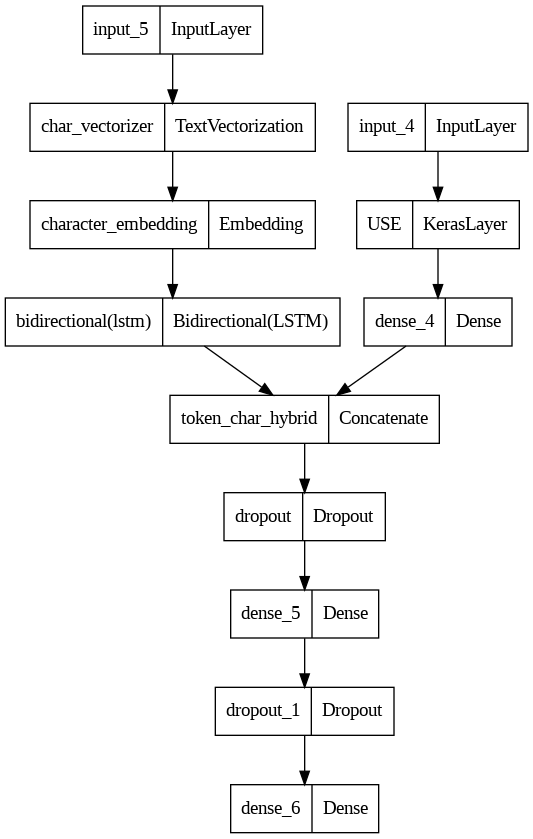

In [ ]:
from keras.utils import plot_model
# Plot hybrid token and character model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy") # Compile token char model

In [ ]:
# Combine chars and tokens into a dataset, Prefetch and batch train and test data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 34ms/step - loss: 0.9847 - accuracy: 0.6079 - val_loss: 0.7755 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.8013 - accuracy: 0.6891 - val_loss: 0.7290 - val_accuracy: 0.7227
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7764 - accuracy: 0.7055 - val_loss: 0.6859 - val_accuracy: 0.7447


In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_preds=tf.argmax(model_4_pred_probs, axis=1)

# Get results of token-char-hybrid model
model_4_res=calculate_results(val_labels_encoded, model_4_preds)
model_4_res

945/945 [==============================] - 18s 18ms/step


{'accuracy': 73.41784721302793,
 'precision': 0.7330950871005683,
 'recall': 0.7341784721302793,
 'f1': 0.7318152269535374}

## Model 5: Transfer learning + token and character embeddings + positional embeddings

In [ ]:
train_df["line_number"].value_counts() # How many different line numbers are there?

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [ ]:
train_df["total_lines"].value_counts() # How many different numbers of lines are there?

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

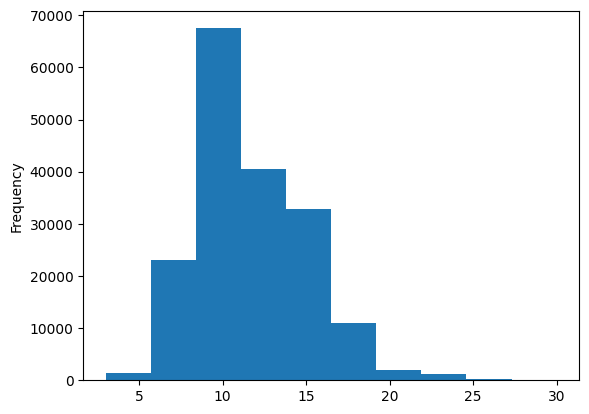

In [ ]:
train_df["total_lines"].plot(kind="hist")

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     


Building a tribrid embedding model

  1. Create a token-level model
  2. Create a character-level model
  3. Create a model for the "line_number" feature
  4. Create a model for the "total_lines" feature
  5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
  6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
  7. Create an output layer to accept the tribrid embedding and output label probabilities
  8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model



In [ ]:
# Token model
token_inputs=tf.keras.layers.Input(shape=[], dtype=tf.string)
x=sentence_encoder(token_inputs)
token_outputs=tf.keras.layers.Dense(128, activation="relu")(x)
token_model=tf.keras.Model(token_inputs, token_outputs)

#Char model
char_inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)
y=char_vectorizer(char_inputs)
y=char_embedding(y)
char_bi_lstm=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(y)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#Line numbers model
line_number_inputs=tf.keras.layers.Input(shape=(15,), dtype=tf.float32)
line_num_dense=tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs, line_num_dense)

#total lines model
total_lines_inputs=tf.keras.layers.Input(shape=(20,), dtype=tf.float32)
total_lines_dense=tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model=tf.keras.Model(total_lines_inputs, total_lines_dense)

#Concatenate the first two models
token_char_concat=tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

z=tf.keras.layers.Dense(256, activation="relu")(token_char_concat)
z=tf.keras.layers.Dropout(0.5)(z)

#combine positional embeddings with token and char model
tribrid_embeddings=tf.keras.layers.Concatenate(name="tribrid_embedding")([line_number_model.output, total_lines_model.output, z])

#Output layer

output_layer=tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#create the full model
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
                         outputs=output_layer,
                         name="model_5_token_char_positional_embeddings")

In [ ]:
model_5.summary()

Model: "model_5_token_char_positional_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_7[0][0]']             
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer="adam", metrics="accuracy")

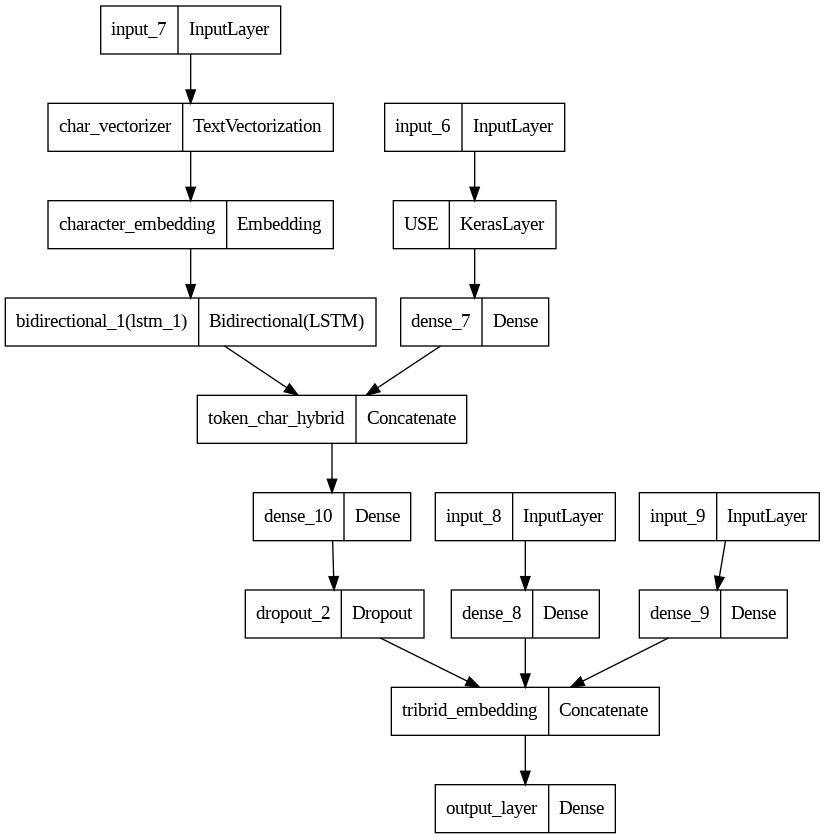

In [ ]:
plot_model(model_5) # Plot model_5 to explore it visually

## Create tribrid embedding datasets using tf.data


In [ ]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_positional_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
train_char_token_positional_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_positional_dataset = tf.data.Dataset.zip((train_char_token_positional_data, train_char_token_positional_labels))
train_char_token_positional_dataset = train_char_token_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_positional_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
val_char_token_positional_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_positional_dataset = tf.data.Dataset.zip((val_char_token_positional_data, val_char_token_positional_labels))
val_char_token_positional_dataset = val_char_token_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_positional_dataset, val_char_token_positional_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit our tribrid embedding model
model_5_history = model_5.fit(train_char_token_positional_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_positional_dataset)),
                              epochs=3,
                              validation_data=val_char_token_positional_dataset,
                              validation_steps=int(0.1 * len(val_char_token_positional_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 38ms/step - loss: 1.0972 - accuracy: 0.7214 - val_loss: 0.9914 - val_accuracy: 0.7969
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9730 - accuracy: 0.8139 - val_loss: 0.9542 - val_accuracy: 0.8215
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9529 - accuracy: 0.8191 - val_loss: 0.9412 - val_accuracy: 0.8241


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs=model_5.predict(val_char_token_positional_dataset)
model_5_preds=tf.argmax(model_5_pred_probs, axis=1)

# Calculate results of char token pos model
model_5_res=calculate_results(val_labels_encoded, model_5_preds)
model_5_res

945/945 [==============================] - 18s 18ms/step


{'accuracy': 82.91738382099828,
 'precision': 0.8280980058962251,
 'recall': 0.8291738382099828,
 'f1': 0.8282499838501034}

## Compare model results


In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": Model_1_res,
                                  "pretrained_token_embed": Model_2_res,
                                  "custom_char_embed_conv1d": Model_3_res,
                                  "hybrid_char_token_embed": model_4_res,
                                  "tribrid_pos_char_token_embed": model_5_res})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.793195,0.784924,0.787932,0.785912
pretrained_token_embed,71.514630,0.715171,0.715146,0.712133
custom_char_embed_conv1d,66.639084,0.660813,0.666391,0.657133
hybrid_char_token_embed,73.417847,0.733095,0.734178,0.731815
tribrid_pos_char_token_embed,82.917384,0.828098,0.829174,0.828250


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

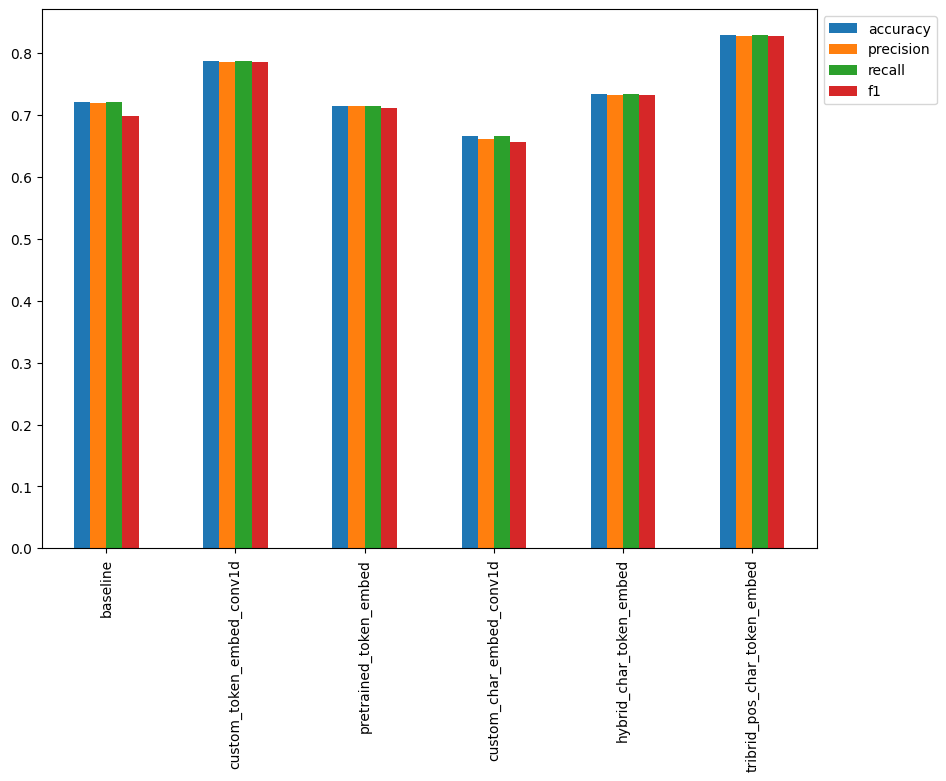

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

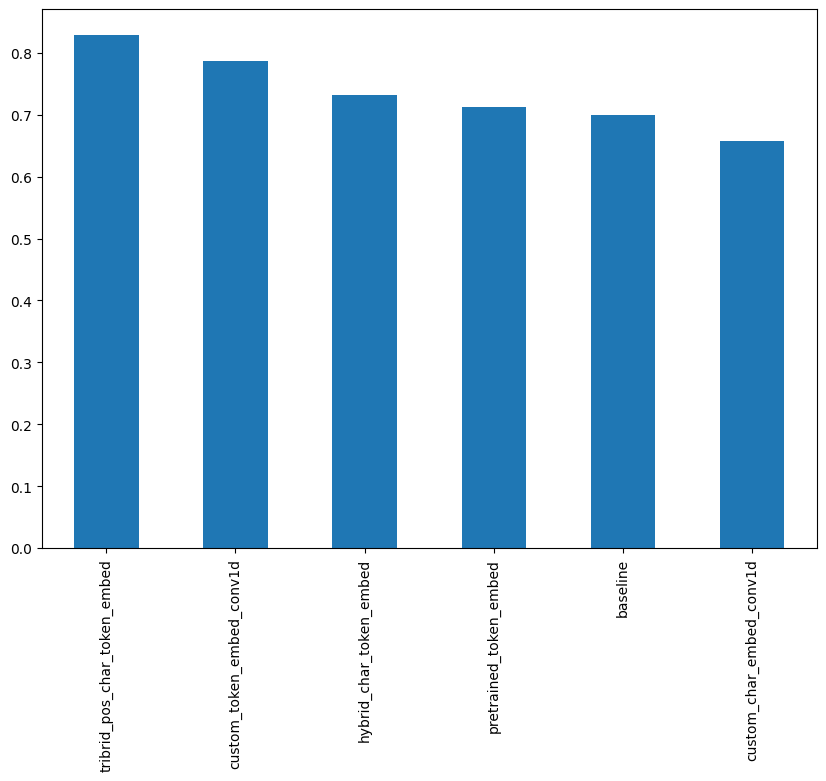

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load model


In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model=tf.keras.models.load_model("/content/skimlit_tribrid_model")

In [ ]:
loaded_model.evaluate(val_char_token_positional_dataset)

945/945 [==============================] - 19s 19ms/step - loss: 0.9369 - accuracy: 0.8328


[0.9369078874588013, 0.8328147530555725]

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-01-04 15:58:27--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.207, 108.177.111.207, 142.250.1.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  67.3MB/s    in 11s     

2024-01-04 15:58:38 (83.3 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/